591 Project

In [2]:
# imports
import pandas as pd
import sqlite3
from sqlite3 import Error
from igraph import *
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
imdb_db = 'datasets/imdb.db'

In [3]:
def pushtoDB(db_file, df, tablename):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        df.to_sql(tablename, conn, if_exists='replace', index=False, chunksize=1000)
    except Error as e:
        sys.exit(e)
    finally:
        if conn:
            conn.close()

def DBQuery(db_file, query):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        c = conn.cursor()
        c.execute(query)
        df = pd.DataFrame(c.fetchall())
        return df
    except Error as e:
        sys.exit(e)
    finally:
        if conn:
            conn.close()

In [31]:
# Movie and Personell Link
principals = pd.read_csv('datasets/title.principals.tsv', sep='\t')

# Movie Basic Details
basics = pd.read_csv('datasets/title.basics.tsv', sep='\t', low_memory=False)

# Persoannel Basic Details
names = pd.read_csv('datasets/name.basics.tsv', sep='\t', low_memory=False)


In [32]:
# clean dataframe
principals.replace('\\N', '', inplace=True)
basics.replace('\\N', '', inplace=True)
names.replace('\\N', '', inplace=True)

basics["startYear"] = pd.to_numeric(basics["startYear"])

In [37]:
pushtoDB(imdb_db, principals, 'principals')
pushtoDB(imdb_db, basics, 'basics')
pushtoDB(imdb_db, names, 'names')

In [ ]:
# Persoannel Basic Details
akas = pd.read_csv('datasets/title.akas.tsv', sep='\t', low_memory=False)
akas.replace('\\N', '', inplace=True)
pushtoDB(imdb_db, akas, 'akas')

In [75]:
# Year
startYear = 2020

In [76]:
edgequery = """
SELECT
	p.nconst, p.tconst, p.category
FROM
	principals p
	JOIN basics b ON p.tconst = b.tconst
WHERE (p.category = 'actor'
	OR p.category = 'actress'
	OR p.category = 'director')
AND b.titleType = 'movie'
AND b.startYear >= """ + str(startYear)

edgelist = DBQuery(imdb_db, edgequery).rename(columns={0: "source", 1: "target", 2: "category"})

In [ ]:
# actors/directors -> movie
# edges attribute has role e.g. actor or director
# edge is directed - acted in the movie or directed the movie
actorMovieg = Graph.DataFrame(edgelist, directed=True)

In [ ]:
# actor <-> actor
# for every movie, get all the actors and actresses
# create a clique for each movie

# get distinct movies from edgelist
uniquemovies = edgelist.target.unique().tolist()

data = []

for a in range(len(uniquemovies)):
    movie = uniquemovies[a]
    actorlist = edgelist[(edgelist.target == movie) & ((edgelist.category == 'actor') | (edgelist.category == 'actress'))].iloc[:, 0].tolist()
    if (len(actorlist) == 1):
        continue
    for i in range(len(actorlist)):
        for j in range(i+1, len(actorlist)):
            data.append([actorlist[i], actorlist[j]])


actorsCollab = pd.DataFrame(data, columns = ['actor1', 'actor2'])

In [ ]:
actorsCollabg = Graph.DataFrame(actorsCollab, directed=False)

In [ ]:
# director -> actor
# for every movie, get all the actors and actresses
# create a clique for each movie

# get distinct movies from edgelist
uniquemovies = edgelist.target.unique().tolist()

data = []

for a in range(len(uniquemovies)):
    movie = uniquemovies[a]
    directorList = edgelist[(edgelist.target == movie) & ((edgelist.category == 'director'))].iloc[:, 0].tolist()
    actorlist = edgelist[(edgelist.target == movie) & ((edgelist.category == 'actor') | (edgelist.category == 'actress'))].iloc[:, 0].tolist()
    for i in range(len(directorList)):
        for j in range(len(actorlist)):
            data.append([directorList[i], actorlist[j]])


directorActorCollab = pd.DataFrame(data, columns = ['director', 'actor'])

In [ ]:
directorActorCollabg = Graph.DataFrame(directorActorCollab, directed=True)

In [ ]:
def getHighestNodes(xlist, g, nodevalue):
    max = 0
    n = ""
    for i in range(len(xlist)):
        if xlist[i] > max:
            max = xlist[i]
            n = g.vs[i][nodevalue]
        elif xlist[i] == max:
            n = n + "; " + g.vs[i][nodevalue]
    return "(" + str(max) + ")" + n

In [ ]:
Names = ["Actor -> Movie <- Director", "Actor - Actor", "Director -> Actor"]
Degs = []
Eccs = []
Clos = []
Btws = []
Katz = []
PgRs = []
Katz = []

for i in range(3):
    if (i == 0):
        g = actorMovieg
    elif (i == 1):
        g = actorsCollabg
    elif (i == 2):
        g = directorActorCollabg

    gNX = g.to_networkx()

    nodevalue = "name"

    # Degree
    deg = g.degree()
    Degs.append(getHighestNodes(deg, g, nodevalue))

    # Eccentricity
    ecc = g.eccentricity()
    Eccs.append(getHighestNodes(ecc, g, nodevalue))

    # Closeness
    clo = g.closeness()
    Clos.append(getHighestNodes(clo, g, nodevalue))

    # Betweenness
    btw = g.betweenness()
    Btws.append(getHighestNodes(btw, g, nodevalue))

    # PageRank
    pgr = g.pagerank()
    PgRs.append(getHighestNodes(pgr, g, nodevalue))

    # Katz Index
    # maxEigen = max(nx.adjacency_spectrum(gNX))
    # alpha = 1/(abs(maxEigen)) * 0.85 # using 0.85 as an arbitrary factor
    # centrality = nx.katz_centrality(gNX, alpha)
    # cclist = list(pd.DataFrame(list(centrality.items()))[1])
    # Katz.append(getHighestNodes(cclist, g, nodevalue))


In [ ]:
data = {'Graph': Names,
        'Max Degree':Degs,
        'Eccentricity': Eccs,
        'Closeness': Clos,
        'Betweenness': Btws,
        'Page Rank': PgRs}
#data = [Names, Degs, Eccs, Clos, Btws, PgRs]

cenMat = pd.DataFrame(data)

In [ ]:
cenMat

,Graph,Max Degree,Eccentricity,Closeness,Betweenness,Page Rank
0,Actor -> Movie <- Director,(9)tt18989324; tt4040980; tt5637536,(1.0)nm0000116; nm0000244; nm0000318; nm000061...,(1.0)nm0000318; nm0000702; nm0004645; nm016084...,(0); nm0000116; nm0000244; nm0000318; nm000061...,(0.02662767431122056)tt18989324; tt4040980
1,Actor - Actor,(10)nm0000706; nm0757855; nm1318596; nm2772105,(2.0)nm12564204; nm1876808; nm2070349; nm38465...,(1.0)nm0000244; nm0000610; nm0000706; nm000164...,(9.0)nm4722180,(0.01932950770160072)nm4722180
2,Director -> Actor,(12)nm0000116,(1.0)nm0000116; nm0005363; nm0204628; nm119271...,(1.0)nm0000116; nm0001467; nm0005363; nm020462...,(0); nm0000116; nm0000244; nm0000610; nm000070...,(0.02490017746228926)nm12564204


In [3]:
slinestatscsv = 'datasets/sline/top3nodes.csv'

slinestats = pd.read_csv(slinestatscsv)

In [6]:
g130df = pd.read_csv('datasets/sline/130.edges', delim_whitespace=True)

g130 = Graph.DataFrame(g130df)

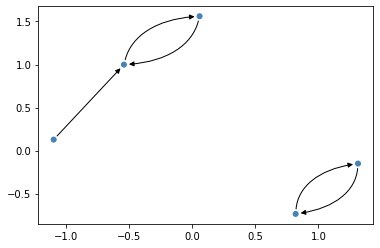

In [12]:
fig, ax = plt.subplots()

plot(g130, target=ax)